### Comenzamos con el ETL

Este código creará un DataFrame con las columnas 'Fecha', 'Criptomoneda', 'Precio', 'Variación 24h', 'Capitalización de mercado' y 'Volumen', y lo llenará con los datos relevantes para las criptomonedas seleccionadas en los últimos tres años.

In [3]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
import datetime

# Inicializar la API de CoinGecko
cg = CoinGeckoAPI()

# Definir los IDs de las criptomonedas que deseas analizar (ejemplo: "bitcoin", "ethereum", etc.)
coin_ids = ["bitcoin", "ethereum", "ripple", "cardano", "solana", "polkadot", "dogecoin", "usd-coin", "tether", "binancecoin"]

# Calcular las fechas para los últimos tres años
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=3 * 365)  # 3 años

# Convertir las fechas a marcas de tiempo UNIX
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Crear un DataFrame vacío para almacenar los datos
columns = ['Fecha', 'Criptomoneda', 'Precio', 'Variación 24h', 'Capitalización de mercado', 'Volumen']
data = []

# Iterar a través de las criptomonedas y obtener los datos relevantes
for coin_id in coin_ids:
    # Obtener información general de la criptomoneda
    coin_info = cg.get_coin_by_id(id=coin_id)
    coin_name = coin_info['name']
    coin_symbol = coin_info['symbol']

    # Obtener el historial de precios en el rango de fechas
    price_history = cg.get_coin_market_chart_range_by_id(id=coin_id, vs_currency='usd', from_timestamp=start_timestamp, to_timestamp=end_timestamp)
    
    # Iterar a través de los datos de historial de precios
    for data_point in price_history['prices']:
        timestamp = data_point[0]
        price = data_point[1]
        
        # Convertir la marca de tiempo a una fecha legible
        date = datetime.datetime.fromtimestamp(timestamp / 1000).strftime('%Y-%m-%d')
        
        # Obtener datos adicionales solo si hay datos disponibles para ese día
        market_data = [entry for entry in price_history['market_caps'] if entry[0] == timestamp]
        if market_data:
            market_cap = market_data[0][1]
        else:
            market_cap = None
        
        volume_data = [entry for entry in price_history['total_volumes'] if entry[0] == timestamp]
        if volume_data:
            volume = volume_data[0][1]
        else:
            volume = None
        
        change_24h = None  # No se proporciona directamente en los datos de historial de precios
        
        # Agregar los datos al DataFrame
        data.append([date, coin_name, price, change_24h, market_cap, volume])

# Crear el DataFrame
df = pd.DataFrame(data, columns=columns)

# Mostrar el DataFrame
print(df)

            Fecha Criptomoneda        Precio Variación 24h  \
0      2020-08-10      Bitcoin  11862.938013          None   
1      2020-08-11      Bitcoin  11398.671061          None   
2      2020-08-12      Bitcoin  11579.867952          None   
3      2020-08-13      Bitcoin  11817.164039          None   
4      2020-08-14      Bitcoin  11777.391322          None   
...           ...          ...           ...           ...   
10937  2023-08-05          BNB    242.881970          None   
10938  2023-08-06          BNB    242.574998          None   
10939  2023-08-07          BNB    241.738425          None   
10940  2023-08-08          BNB    245.179427          None   
10941  2023-08-09          BNB    244.010315          None   

       Capitalización de mercado       Volumen  
0                   2.189203e+11  2.414592e+10  
1                   2.108256e+11  2.444870e+10  
2                   2.137709e+11  2.280378e+10  
3                   2.171850e+11  2.475577e+10  
4         

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10942 entries, 0 to 10941
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Fecha                      10942 non-null  object 
 1   Criptomoneda               10942 non-null  object 
 2   Precio                     10942 non-null  float64
 3   Variación 24h              0 non-null      object 
 4   Capitalización de mercado  10942 non-null  float64
 5   Volumen                    10942 non-null  float64
dtypes: float64(3), object(3)
memory usage: 513.0+ KB


In [5]:
# Calcular la variación en las últimas 24 horas
df['Variación 24h'] = df.groupby('Criptomoneda')['Precio'].pct_change(periods=1) * 100

# Convertir 'Fecha' a tipo de dato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Mostrar el DataFrame con los cambios aplicados
print(df)


           Fecha Criptomoneda        Precio  Variación 24h  \
0     2020-08-10      Bitcoin  11862.938013            NaN   
1     2020-08-11      Bitcoin  11398.671061      -3.913592   
2     2020-08-12      Bitcoin  11579.867952       1.589632   
3     2020-08-13      Bitcoin  11817.164039       2.049212   
4     2020-08-14      Bitcoin  11777.391322      -0.336567   
...          ...          ...           ...            ...   
10937 2023-08-05          BNB    242.881970       0.575490   
10938 2023-08-06          BNB    242.574998      -0.126387   
10939 2023-08-07          BNB    241.738425      -0.344872   
10940 2023-08-08          BNB    245.179427       1.423441   
10941 2023-08-09          BNB    244.010315      -0.476840   

       Capitalización de mercado       Volumen  
0                   2.189203e+11  2.414592e+10  
1                   2.108256e+11  2.444870e+10  
2                   2.137709e+11  2.280378e+10  
3                   2.171850e+11  2.475577e+10  
4         

In [6]:
# Formatear los valores de las columnas "Capitalización de mercado" y "Volumen"
df['Capitalización de mercado'] = df['Capitalización de mercado'].apply(lambda x: '${:,.2f}'.format(x))
df['Volumen'] = df['Volumen'].apply(lambda x: '${:,.2f}'.format(x))

# Convertir los valores en formato científico a números
df['Capitalización de mercado'] = df['Capitalización de mercado'].apply(lambda x: x.replace('$', '').replace(',', ''))
df['Volumen'] = df['Volumen'].apply(lambda x: x.replace('$', '').replace(',', ''))

# Mostrar el DataFrame con los valores formateados y convertidos
print(df)


           Fecha Criptomoneda        Precio  Variación 24h  \
0     2020-08-10      Bitcoin  11862.938013            NaN   
1     2020-08-11      Bitcoin  11398.671061      -3.913592   
2     2020-08-12      Bitcoin  11579.867952       1.589632   
3     2020-08-13      Bitcoin  11817.164039       2.049212   
4     2020-08-14      Bitcoin  11777.391322      -0.336567   
...          ...          ...           ...            ...   
10937 2023-08-05          BNB    242.881970       0.575490   
10938 2023-08-06          BNB    242.574998      -0.126387   
10939 2023-08-07          BNB    241.738425      -0.344872   
10940 2023-08-08          BNB    245.179427       1.423441   
10941 2023-08-09          BNB    244.010315      -0.476840   

      Capitalización de mercado         Volumen  
0               218920276229.41  24145919191.34  
1               210825577055.42  24448699831.26  
2               213770877597.90  22803776234.98  
3               217185020504.78  24755770184.14  
4    

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10942 entries, 0 to 10941
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Fecha                      10942 non-null  datetime64[ns]
 1   Criptomoneda               10942 non-null  object        
 2   Precio                     10942 non-null  float64       
 3   Variación 24h              10932 non-null  float64       
 4   Capitalización de mercado  10942 non-null  object        
 5   Volumen                    10942 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 513.0+ KB


## Elegí las criptomonedas con mayor capitalización de mercado como parte de mi estrategia es sólido por varias razones:

*Estabilidad y Reconocimiento:* Las criptomonedas con mayor capitalización de mercado suelen ser las más estables y reconocidas en el mercado. Tienen una base de usuarios más grande y un historial más largo, lo que a menudo se traduce en una mayor confianza por parte de los inversores y una menor volatilidad en comparación con las monedas más pequeñas y menos conocidas.

*Referencia del Mercado:* Las criptomonedas con mayor capitalización de mercado a menudo se utilizan como referencia para evaluar el rendimiento general del mercado de criptomonedas. Los movimientos de precios y tendencias en estas criptomonedas pueden influir en las decisiones de inversión y análisis de otros activos digitales.

*Liquidez:* Las criptomonedas con mayor capitalización de mercado generalmente tienen una mayor liquidez en los mercados de intercambio. Esto significa que hay más volumen de negociación y, por lo tanto, es más fácil comprar y vender estas monedas sin afectar significativamente los precios.

*Análisis Comparativo:* Al elegir las criptomonedas más grandes, puedes realizar un análisis comparativo más sólido y significativo. Puedes examinar cómo estas monedas han respondido a eventos pasados, su correlación con otros activos y cómo se comportan en relación con el mercado en general.

*Mayor Disponibilidad de Datos:* Las criptomonedas con mayor capitalización de mercado suelen tener una mayor disponibilidad de datos históricos y análisis en línea. Esto facilita la investigación y el análisis fundamental y técnico.

*Atracción para Inversionistas Institucionales:* Las criptomonedas con alta capitalización de mercado a menudo son el objetivo de inversores institucionales y fondos de inversión, lo que puede tener un impacto significativo en sus precios y adopción.

*Seguimiento en el Tiempo:* Puedes realizar un seguimiento más efectivo de estas monedas en el tiempo, lo que te permite observar cómo han evolucionado a lo largo del tiempo y cómo han enfrentado diferentes desafíos y tendencias del mercado.

En resumen, elegir las criptomonedas con mayor capitalización de mercado es una estrategia sólida debido a su estabilidad, reconocimiento, liquidez y su papel como referencia en el mercado.

**Bitcoin (BTC) y Ethereum (ETH):** No es sorprendente que Bitcoin y Ethereum ocupen los dos primeros lugares en términos de capitalización de mercado. Bitcoin es ampliamente conocido como la primera y más grande criptomoneda, mientras que Ethereum ha impulsado el desarrollo de aplicaciones descentralizadas y contratos inteligentes.

**Tether (USDT):** Tether es una stablecoin, lo que significa que su valor está vinculado al dólar estadounidense. Su alta capitalización de mercado indica su importancia como moneda estable para la negociación y la liquidez en el mercado de criptomonedas.

**BNB (Binance Coin):** Binance Coin es la criptomoneda nativa del intercambio Binance. Su alta capitalización sugiere su adopción y uso en la plataforma Binance, así como su papel en la financiación de proyectos a través de ofertas de monedas iniciales (ICOs) en el pasado.

**XRP:** XRP es la criptomoneda asociada a Ripple y su red de pago transfronterizo. A pesar de las controversias legales en torno a Ripple, su posición en el top 5 en términos de capitalización de mercado indica que aún mantiene un fuerte interés y actividad.

**USD Coin (USDC):** Al igual que Tether, USD Coin es otra stablecoin que está respaldada por una reserva de dólares estadounidenses en custodia. Su capitalización muestra la demanda de monedas estables en el ecosistema de criptomonedas.


**Dogecoin:** Aunque inicialmente comenzó como una broma, Dogecoin ha ganado atención y popularidad en la comunidad de criptomonedas y más allá. Su lugar en el top 10 muestra el poder de la comunidad y el interés en activos menos convencionales.

**Cardano (ADA):** Cardano es una plataforma blockchain que busca mejorar la escalabilidad y sostenibilidad. Su alta capitalización muestra el interés en sus capacidades técnicas y su enfoque en la investigación académica.

**Solana (SOL):** Solana es una plataforma de contrato inteligente de alto rendimiento que ha ganado atención debido a su velocidad y escalabilidad. Su posición en el top 10 sugiere que los inversores y desarrolladores están interesados en alternativas a Ethereum.

**Polkadot:** Polkadot es un protocolo que permite la transferencia de cualquier tipo de datos o activos entre cadenas de bloques. Su objetivo es ofrecer una mayor seguridad y escalabilidad al conectar diferentes blockchains. Su moneda nativa es el DOT, que se usa para participar en la gobernancia, la validación y la creación de nuevas cadenas

En resumen, la capitalización de mercado es una medida importante de la relevancia y adopción de las criptomonedas en el mercado. La presencia de una variedad de tipos de criptomonedas en el top 10 refleja la diversidad de casos de uso y tecnologías en el ecosistema de criptomonedas

## Comenzamos con EDA (Exploratory Data Analysis)

Exploración inicial:

In [9]:
# Muestra las primeras filas del DataFrame
print(df.head())

       Fecha Criptomoneda        Precio  Variación 24h  \
0 2020-08-10      Bitcoin  11862.938013            NaN   
1 2020-08-11      Bitcoin  11398.671061      -3.913592   
2 2020-08-12      Bitcoin  11579.867952       1.589632   
3 2020-08-13      Bitcoin  11817.164039       2.049212   
4 2020-08-14      Bitcoin  11777.391322      -0.336567   

  Capitalización de mercado         Volumen  
0           218920276229.41  24145919191.34  
1           210825577055.42  24448699831.26  
2           213770877597.90  22803776234.98  
3           217185020504.78  24755770184.14  
4           216916952670.30  21650925952.00  


In [10]:
# Información sobre las columnas y tipos de datos
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10942 entries, 0 to 10941
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Fecha                      10942 non-null  datetime64[ns]
 1   Criptomoneda               10942 non-null  object        
 2   Precio                     10942 non-null  float64       
 3   Variación 24h              10932 non-null  float64       
 4   Capitalización de mercado  10942 non-null  object        
 5   Volumen                    10942 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 513.0+ KB
None


In [11]:
# Estadísticas descriptivas
print(df.describe())


             Precio  Variación 24h
count  10942.000000   10932.000000
mean    3487.609585       0.265097
std    10686.103278       6.291078
min        0.002520     -42.278951
25%        0.954486      -1.567330
50%        2.117634       0.008149
75%      303.001001       1.692486
max    67617.015545     338.901068


Valores faltantes:

In [13]:
# Verificar valores faltantes por columna
missing_values = df.isnull().sum()
print(missing_values)

Fecha                         0
Criptomoneda                  0
Precio                        0
Variación 24h                10
Capitalización de mercado     0
Volumen                       0
dtype: int64


En este caso, los 10 valores faltantes en la variación de 24 horas son del primer día de hace 3 años, por lo que simplemente los voy a cambiar por 0%.

In [14]:
# Reemplazar los valores faltantes en la columna "Variación 24h" por 0%
df['Variación 24h'].fillna(0, inplace=True)

# Mostrar el DataFrame con los valores actualizados
print(df)


           Fecha Criptomoneda        Precio  Variación 24h  \
0     2020-08-10      Bitcoin  11862.938013       0.000000   
1     2020-08-11      Bitcoin  11398.671061      -3.913592   
2     2020-08-12      Bitcoin  11579.867952       1.589632   
3     2020-08-13      Bitcoin  11817.164039       2.049212   
4     2020-08-14      Bitcoin  11777.391322      -0.336567   
...          ...          ...           ...            ...   
10937 2023-08-05          BNB    242.881970       0.575490   
10938 2023-08-06          BNB    242.574998      -0.126387   
10939 2023-08-07          BNB    241.738425      -0.344872   
10940 2023-08-08          BNB    245.179427       1.423441   
10941 2023-08-09          BNB    244.010315      -0.476840   

      Capitalización de mercado         Volumen  
0               218920276229.41  24145919191.34  
1               210825577055.42  24448699831.26  
2               213770877597.90  22803776234.98  
3               217185020504.78  24755770184.14  
4    

No hay necesidad de tratar duplicados ni outliers en este análisis exploratorio ya que la data se está extrayendo limpia desde CoinGecko.

## Gráficos para Análisis Visual:

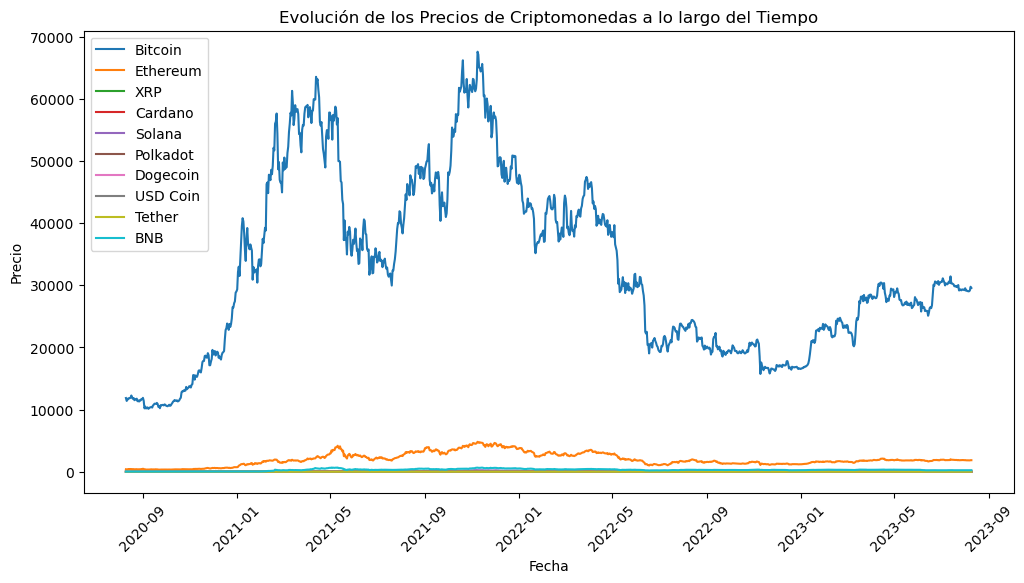

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de criptomonedas seleccionadas
criptomonedas_seleccionadas = ['Bitcoin', 'Ethereum', 'XRP', 'Cardano', 'Solana', 'Polkadot', 'Dogecoin', 'USD Coin', 'Tether', 'BNB']

# Filtrar el DataFrame para las criptomonedas seleccionadas
df_seleccionado = df[df['Criptomoneda'].isin(criptomonedas_seleccionadas)]

# Crear el gráfico de línea temporal
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_seleccionado, x='Fecha', y='Precio', hue='Criptomoneda')
plt.title('Evolución de los Precios de Criptomonedas a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()


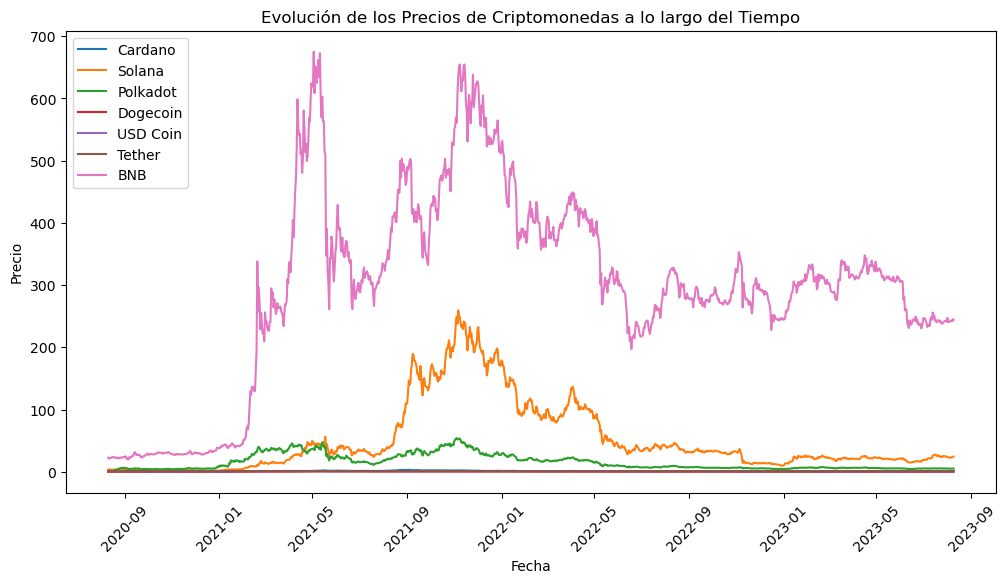

In [20]:

# Lista de criptomonedas seleccionadas
criptomonedas_seleccionadas = ['Cardano', 'Solana', 'Polkadot', 'Dogecoin', 'USD Coin', 'Tether', 'BNB']

# Filtrar el DataFrame para las criptomonedas seleccionadas
df_seleccionado = df[df['Criptomoneda'].isin(criptomonedas_seleccionadas)]

# Crear el gráfico de línea temporal
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_seleccionado, x='Fecha', y='Precio', hue='Criptomoneda')
plt.title('Evolución de los Precios de Criptomonedas a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()


Bitcoin es la criptomoneda más cara y más estable de las que se muestran en el gráfico, seguida por BNB y Solana.

XRP, Cardano y Polkadot tienen precios similares y una tendencia alcista desde finales de 2020.

Dogecoin y Tether Coin son las criptomonedas más baratas y más volátiles de las que se muestran en el gráfico, con picos y caídas abruptas en 2021.

El año 2021 ha sido el más favorable para el crecimiento de las criptomonedas, con un aumento generalizado de los precios y una mayor popularidad

El segundo gráfico muestra que Solana y BNB han tenido un crecimiento sostenido y superior al de las otras criptomonedas, mientras que Dogecoin y Tether han tenido una mayor volatilidad y una tendencia a la baja.

El segundo gráfico también muestra que Cardano y Polkadot han tenido un comportamiento similar al de Solana y BNB, pero con un menor precio y una menor velocidad de crecimiento.

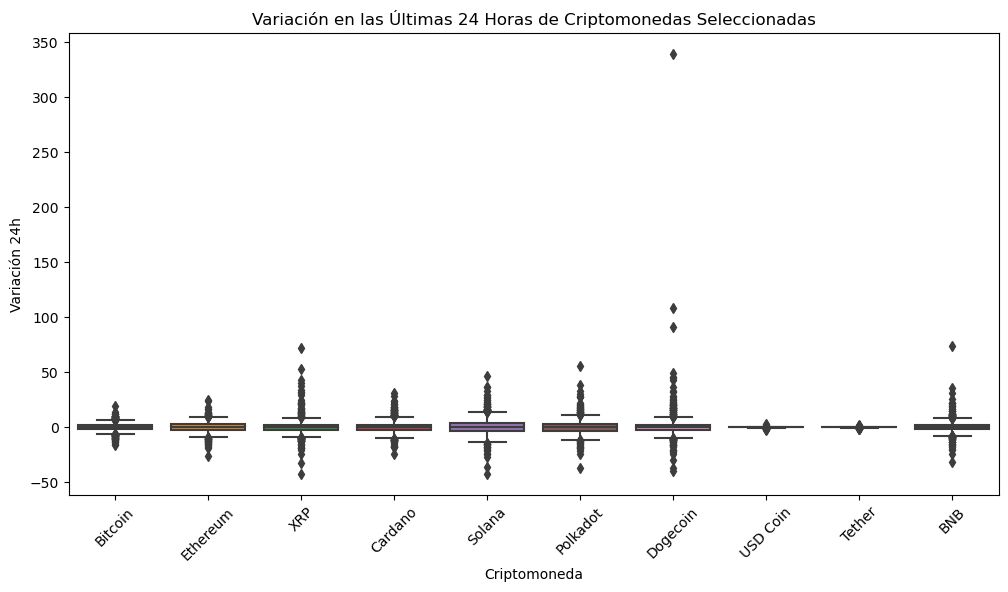

In [21]:
# Filtrar el DataFrame para las criptomonedas seleccionadas (si es necesario)
criptomonedas_seleccionadas = ['Bitcoin', 'Ethereum', 'XRP', 'Cardano', 'Solana', 'Polkadot', 'Dogecoin', 'USD Coin', 'Tether', 'BNB']
df_seleccionado = df[df['Criptomoneda'].isin(criptomonedas_seleccionadas)]

# Crear el gráfico de boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_seleccionado, x='Criptomoneda', y='Variación 24h')
plt.title('Variación en las Últimas 24 Horas de Criptomonedas Seleccionadas')
plt.xlabel('Criptomoneda')
plt.ylabel('Variación 24h')
plt.xticks(rotation=45)
plt.show()

Las monedas que mas han variado son Dogecoin, XRP y BNB

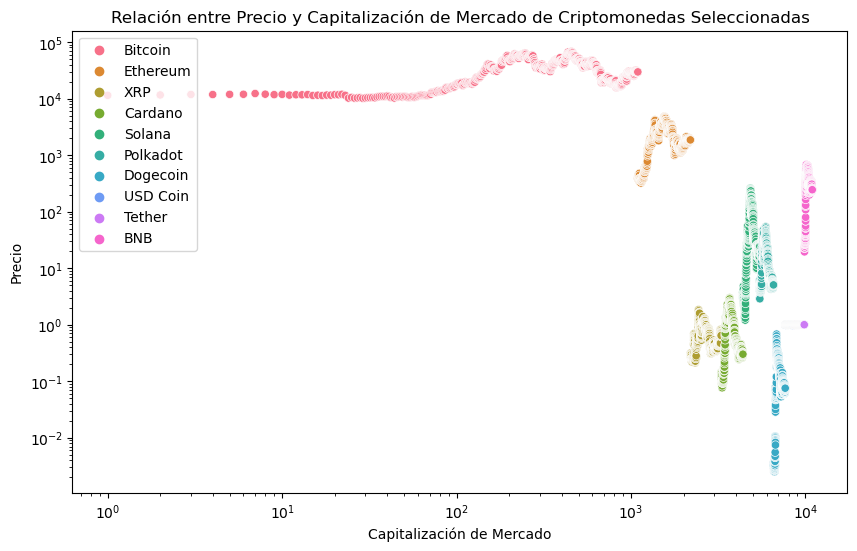

In [23]:
# Filtrar el DataFrame para las criptomonedas seleccionadas (si es necesario)
criptomonedas_seleccionadas = ['Bitcoin', 'Ethereum', 'XRP', 'Cardano', 'Solana', 'Polkadot', 'Dogecoin', 'USD Coin', 'Tether', 'BNB']
df_seleccionado = df[df['Criptomoneda'].isin(criptomonedas_seleccionadas)]

# Crear una paleta de colores personalizada
colores = sns.color_palette("husl", n_colors=len(criptomonedas_seleccionadas))

# Crear el gráfico de dispersión con la paleta personalizada
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_seleccionado, x='Capitalización de mercado', y='Precio', hue='Criptomoneda', palette=colores)
plt.title('Relación entre Precio y Capitalización de Mercado de Criptomonedas Seleccionadas')
plt.xlabel('Capitalización de Mercado')
plt.ylabel('Precio')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left')
plt.show()

De este gráfico, se pueden concluir algunas cosas:

El precio y la capitalización de mercado de las criptomonedas tienen una relación positiva, es decir, a mayor capitalización de mercado, mayor precio, y viceversa.

Bitcoin y Ethereum son las criptomonedas con mayor capitalización de mercado y precio, lo que indica que son las más demandadas y aceptadas en el mercado.

Solana y Polkadot son las criptomonedas con mayor crecimiento relativo en el último año, lo que indica que tienen un alto potencial de innovación y adopción.

Dogecoin es la criptomoneda con menor capitalización de mercado y precio, lo que indica que es una moneda más especulativa y volátil que las demás.

USD Coin y BNB son las criptomonedas con menor variación en el precio, lo que indica que son más estables y confiables que las demás.

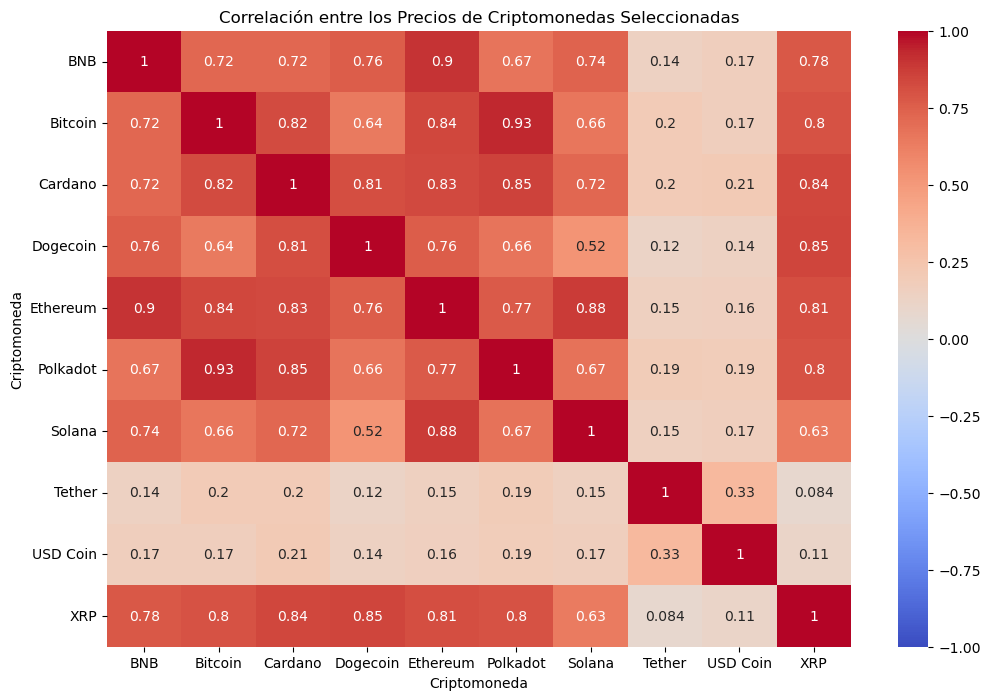

In [25]:
# Filtrar el DataFrame para las criptomonedas seleccionadas (si es necesario)
criptomonedas_seleccionadas = ['Bitcoin', 'Ethereum', 'XRP', 'Cardano', 'Solana', 'Polkadot', 'Dogecoin', 'USD Coin', 'Tether', 'BNB']
df_seleccionado = df[df['Criptomoneda'].isin(criptomonedas_seleccionadas)]

# Calcular la matriz de correlación entre los precios de las criptomonedas
correlation_matrix = df_seleccionado.pivot_table(index='Fecha', columns='Criptomoneda', values='Precio')

# Crear el gráfico de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=correlation_matrix.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación entre los Precios de Criptomonedas Seleccionadas')
plt.show()

La correlación es una medida de la relación lineal entre dos variables, que puede variar entre -1 y 1. Una correlación cercana a 1 indica una relación positiva fuerte, una correlación cercana a -1 indica una relación negativa fuerte, y una correlación cercana a 0 indica una relación débil o nula.

El gráfico muestra que algunas criptomonedas tienen una correlación positiva alta entre sí, como Bitcoin, Ethereum, Cardano, Polkadot y XRP. Esto significa que sus precios tienden a moverse en la misma dirección y con una magnitud similar.

El gráfico también muestra que algunas criptomonedas tienen una correlación negativa baja entre sí, como Dogecoin, Solana, Tether y BNB. Esto significa que sus precios tienden a moverse en direcciones opuestas y con una magnitud diferente.

El gráfico también muestra que algunas criptomonedas tienen una correlación cercana a cero entre sí, como Dogecoin y Bitcoin, Solana y Ethereum, Tether y Cardano, etc. Esto significa que sus precios no tienen una relación lineal clara y pueden variar de forma aleatoria.

In [30]:
df

,Fecha,Criptomoneda,Precio,Variación 24h,Capitalización de mercado,Volumen
0,2020-08-10,Bitcoin,11862.938013,0.000000,218920276229.41,24145919191.34
1,2020-08-11,Bitcoin,11398.671061,-3.913592,210825577055.42,24448699831.26
2,2020-08-12,Bitcoin,11579.867952,1.589632,213770877597.90,22803776234.98
3,2020-08-13,Bitcoin,11817.164039,2.049212,217185020504.78,24755770184.14
4,2020-08-14,Bitcoin,11777.391322,-0.336567,216916952670.30,21650925952.00
...,...,...,...,...,...,...
10937,2023-08-05,BNB,242.881970,0.575490,37367854737.82,251536722.08
10938,2023-08-06,BNB,242.574998,-0.126387,37324600944.79,372359290.68
10939,2023-08-07,BNB,241.738425,-0.344872,37176907148.64,410120374.06
10940,2023-08-08,BNB,245.179427,1.423441,37713239950.15,470639117.91


A continuación, guardaré el DataFrame en un archivo csv para realizar el informe Dashboard en PowerBI

In [31]:
df.to_csv("Monedas.csv")
